In [1]:
import numpy as np
import pickle as pickle
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

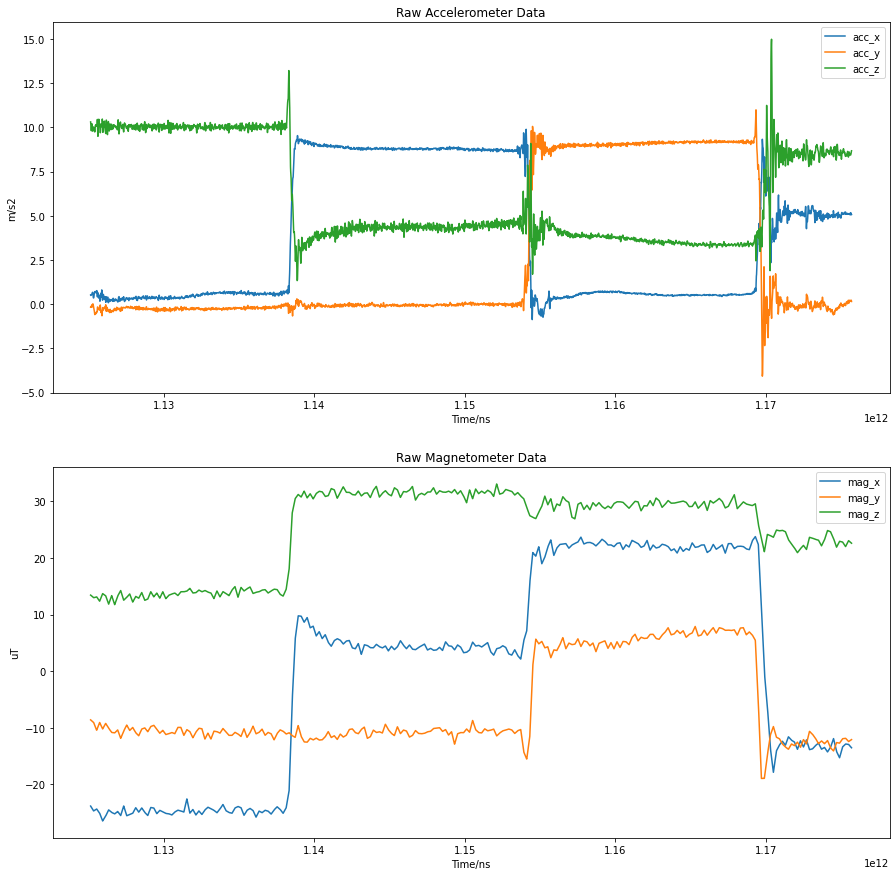

In [2]:
with open("./aggregated.pkl", "rb") as fid:
    data = pickle.load(fid)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

# Retrieve ACC data.                                                                                                                                                    
ts_ACC = data['ACC'][:,0]  # Timestamps for ACC data.
acc_x = data['ACC'][:,1]
acc_y = data['ACC'][:,2]
acc_z = data['ACC'][:,3]

# Retrieve MAG data.
ts_MAG = data['MAG'][:,0]  # Timestamps for MAG data.
mag_x = data['MAG'][:,1]
mag_y = data['MAG'][:,2]
mag_z = data['MAG'][:,3]

# Orientation results.
ts_ORI = data['ORI'][:,0]  # Timestamps for ORIENTATION data.
pitch_ref = data['ORI'][:,1]
yaw_ref = data['ORI'][:,2]
roll_ref = data['ORI'][:,3]

# Plot ACC data.
ax1.plot(ts_ACC, acc_x)
ax1.plot(ts_ACC, acc_y)
ax1.plot(ts_ACC, acc_z)
ax1.set(xlabel='Time/ns', ylabel='m/s2', title='Raw Accelerometer Data')
ax1.legend(['acc_x', 'acc_y', 'acc_z'])

# Plot MAG data.
ax2.plot(ts_MAG, mag_x)
ax2.plot(ts_MAG, mag_y)
ax2.plot(ts_MAG, mag_z)
ax2.set(xlabel='Time/ns', ylabel='uT', title='Raw Magnetometer Data')
ax2.legend(['mag_x', 'mag_y', 'mag_z'])

# Question 2a

In [3]:

class Preprocessing:

    def __init__(self, acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z


    @staticmethod
    def normalize(a, b, c):
        return 1 / (np.sqrt(((a**2) + (b**2) + (c**2))))
    

    def getRotationMatrix(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):
        a = np.array(([acc_x], [acc_y], [acc_z]))
        m = np.array(([mag_x], [mag_y], [mag_z]))
        a_cross_m = np.cross(a, m, axis=0)
        a_cross_m_a = np.cross(a_cross_m, a, axis=0)

        col0 = Preprocessing.normalize(a_cross_m_a[0], a_cross_m_a[1], a_cross_m_a[2]) * a_cross_m_a
        col1 = Preprocessing.normalize(a_cross_m[0], a_cross_m[1], a_cross_m[2]) * a_cross_m
        col2 = Preprocessing.normalize(a[0], a[1], a[2]) * a

        R = np.hstack((
            col0,
            col1,
            col2
        ))

        return R

    
    def getOrientation(R):
        pitch = - np.arcsin(R[0][2])
        yaw = np.arctan2(R[1][2],R[2][2])
        roll = np.arctan2(R[0][1],R[0][0])

        return (pitch, yaw, roll)


all_pitch = []
all_yaw = []
all_roll = []

for i in range(len(acc_x)):
    R = Preprocessing.getRotationMatrix(acc_x[i], acc_y[i], acc_z[i], mag_x[i], mag_y[i], mag_z[i])
    (pitch, yaw, roll) = Preprocessing.getOrientation(R)
    all_pitch.append(pitch)
    all_yaw.append(yaw)
    all_roll.append(roll)

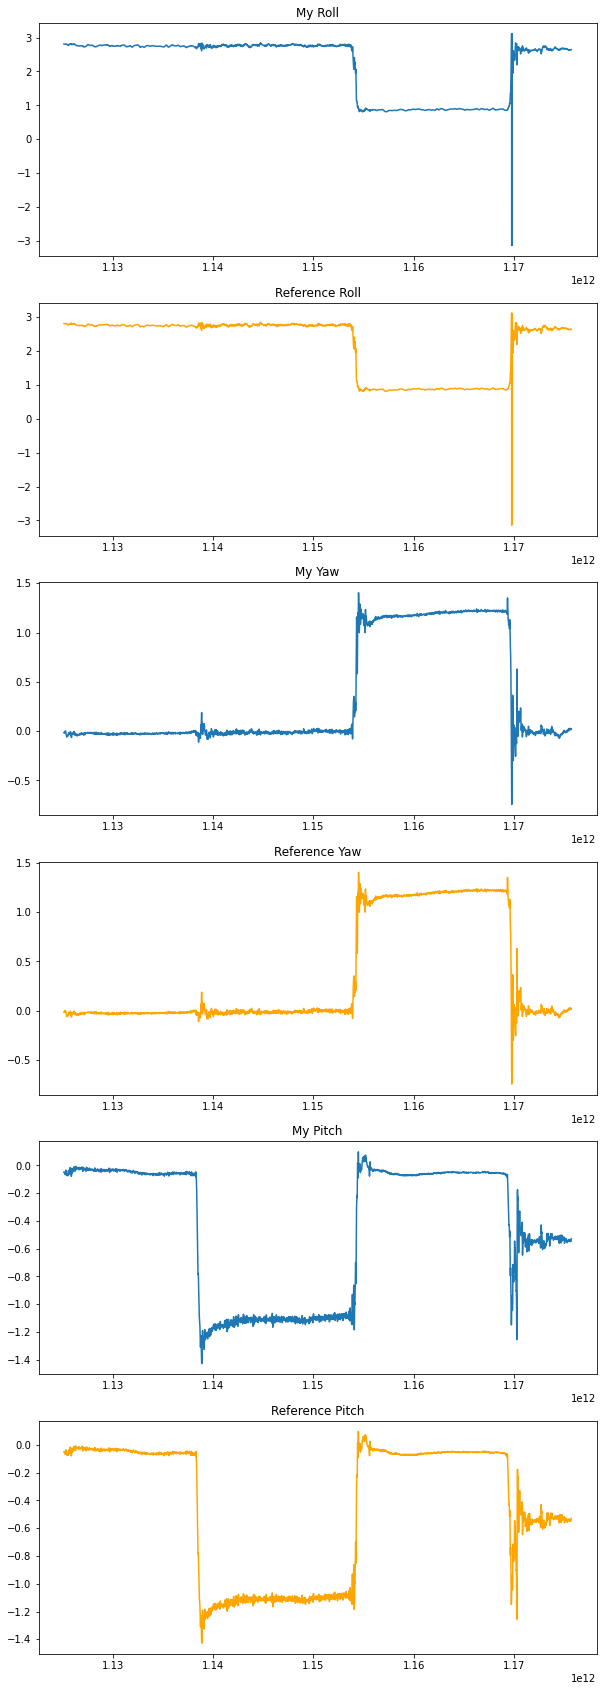

In [4]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10,30))

ax1.plot(ts_ORI, all_roll)
ax1.title.set_text('My Roll')
ax2.plot(ts_ORI, roll_ref, color='orange')
ax2.title.set_text('Reference Roll')

ax3.plot(ts_ORI, all_yaw)
ax3.title.set_text('My Yaw')
ax4.plot(ts_ORI, yaw_ref, color='orange')
ax4.title.set_text('Reference Yaw')


ax5.plot(ts_ORI, all_pitch)
ax5.title.set_text('My Pitch')
ax6.plot(ts_ORI, pitch_ref, color='orange')
ax6.title.set_text('Reference Pitch')



# Question 2b

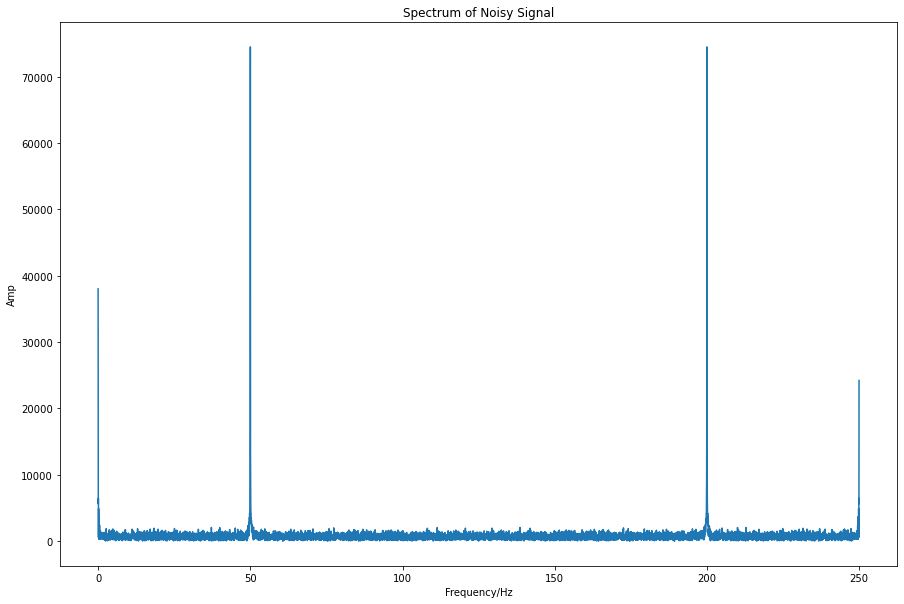

Frequcies of interest/Hz: [[  0.        ]
 [ 49.98419056]
 [ 50.01053963]
 [199.98946037]
 [200.01580944]] 



In [12]:
# Unpickle the file 'synthetic.pkl'
with open("synthetic.pkl", "rb") as fid:
    data = pickle.load(fid)

ts_noisy_acc = data['ACC'][:,0]    
noisy_acc_x = data['ACC'][:,1]
noisy_acc_y = data['ACC'][:,2]
noisy_acc_z = data['ACC'][:,3]
noisy_acc = [noisy_acc_x,noisy_acc_y,noisy_acc_z]


ts_noisy_mag = data['MAG'][:,0]  
noisy_mag_x = data['MAG'][:,1]
noisy_mag_y = data['MAG'][:,2]
noisy_mag_z = data['MAG'][:,3]
noisy_mag = [noisy_mag_x,noisy_mag_y,noisy_mag_z]

# fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(ts_noisy_acc, noisy_acc_z)

# Carry out an FFT analysis on the acc_x and plot the spectrum.
sample_freq = 250
frequency = np.arange(len(noisy_acc_x)) * (sample_freq/len(noisy_acc_x))
spectrum=np.abs(fft(noisy_acc_x))

fig, ax = plt.subplots(figsize=(15,10))


ax.plot(frequency, spectrum)
ax.set(xlabel = 'Frequency/Hz',
      ylabel = 'Amp',
      title = 'Spectrum of Noisy Signal')

plt.show()

# spectrum_abs = np.abs(spectrum)
# Identity location of peaks
threshold= np.max(spectrum)/2.0 #this threshold criteria will not capture the smaller peaks
# threshold = 20000
indices = np.argwhere( spectrum > threshold)
print('Frequcies of interest/Hz: %s \n' % frequency[indices])

# Design a suitable filter to remove the noise.


# Run the filter over the dataset.

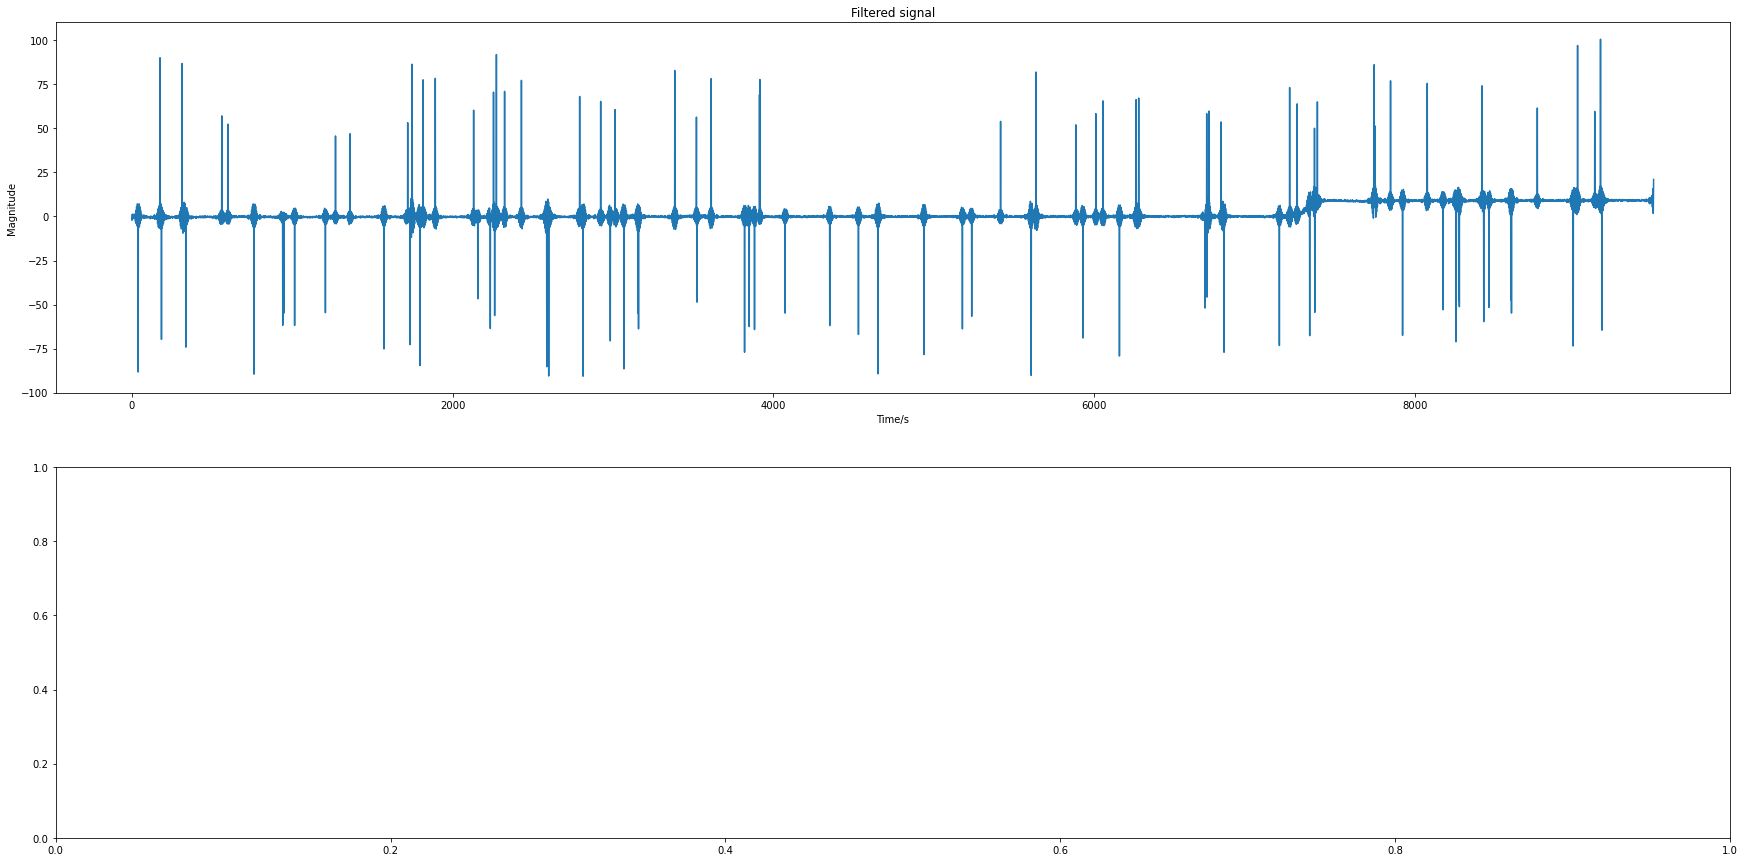

In [34]:
from scipy import signal

N = 4
cutOff = [45.0/(sample_freq/2),55.0/(sample_freq/2)]
btype = 'bandstop'

# N = 4
# cutOff = 2.0/(sample_freq/2)
# btype = 'low'

b, a = signal.butter(N, cutOff, btype)
LP_filter_acc = []
LP_filter_mag = []
for n in noisy_acc:
  LP_filter_acc.append(signal.filtfilt(b, a, n))

for n in noisy_mag:
  LP_filter_mag.append(signal.filtfilt(b, a, n))
  
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,15))
ax1.plot(LP_filter_acc[1])
ax1.set(xlabel = 'Time/s',
      ylabel = 'Magnitude',
      title = 'Filtered signal')
plt.show()

NameError: name 'all_noisy_roll' is not defined

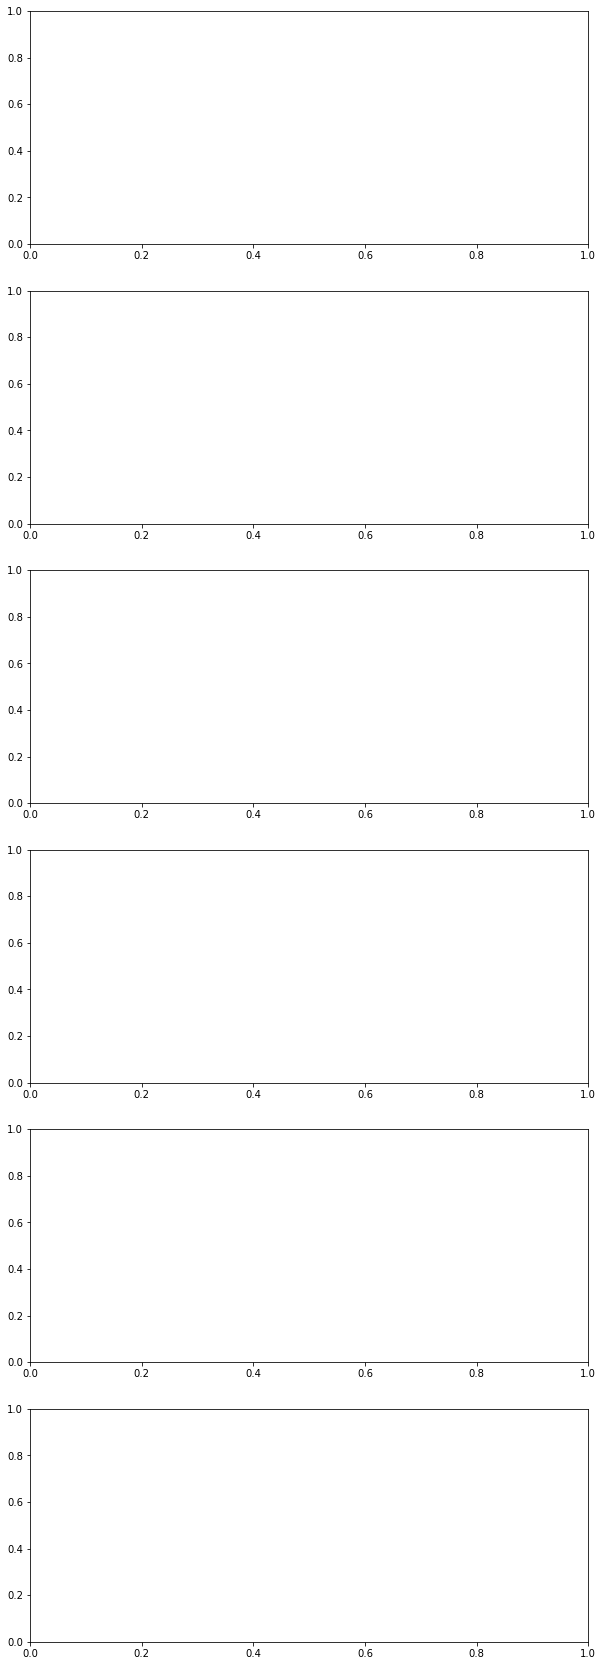

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10,30))

ax1.plot(ts_noisy_mag, all_noisy_roll)
ax1.title.set_text('My Roll')
ax2.plot(ts_noisy_mag, roll_ref, color='r')
ax2.title.set_text('Reference Roll')

ax3.plot(ts_noisy_mag, all_noisy_yaw)
ax3.title.set_text('My Yaw')
ax4.plot(ts_noisy_mag, yaw_ref, color='r')
ax4.title.set_text('Reference Yaw')


ax5.plot(ts_noisy_mag, all_noisy_pitch)
ax5.title.set_text('My Pitch')
ax6.plot(ts_noisy_mag, pitch_ref, color='r')
ax6.title.set_text('Reference Pitch')

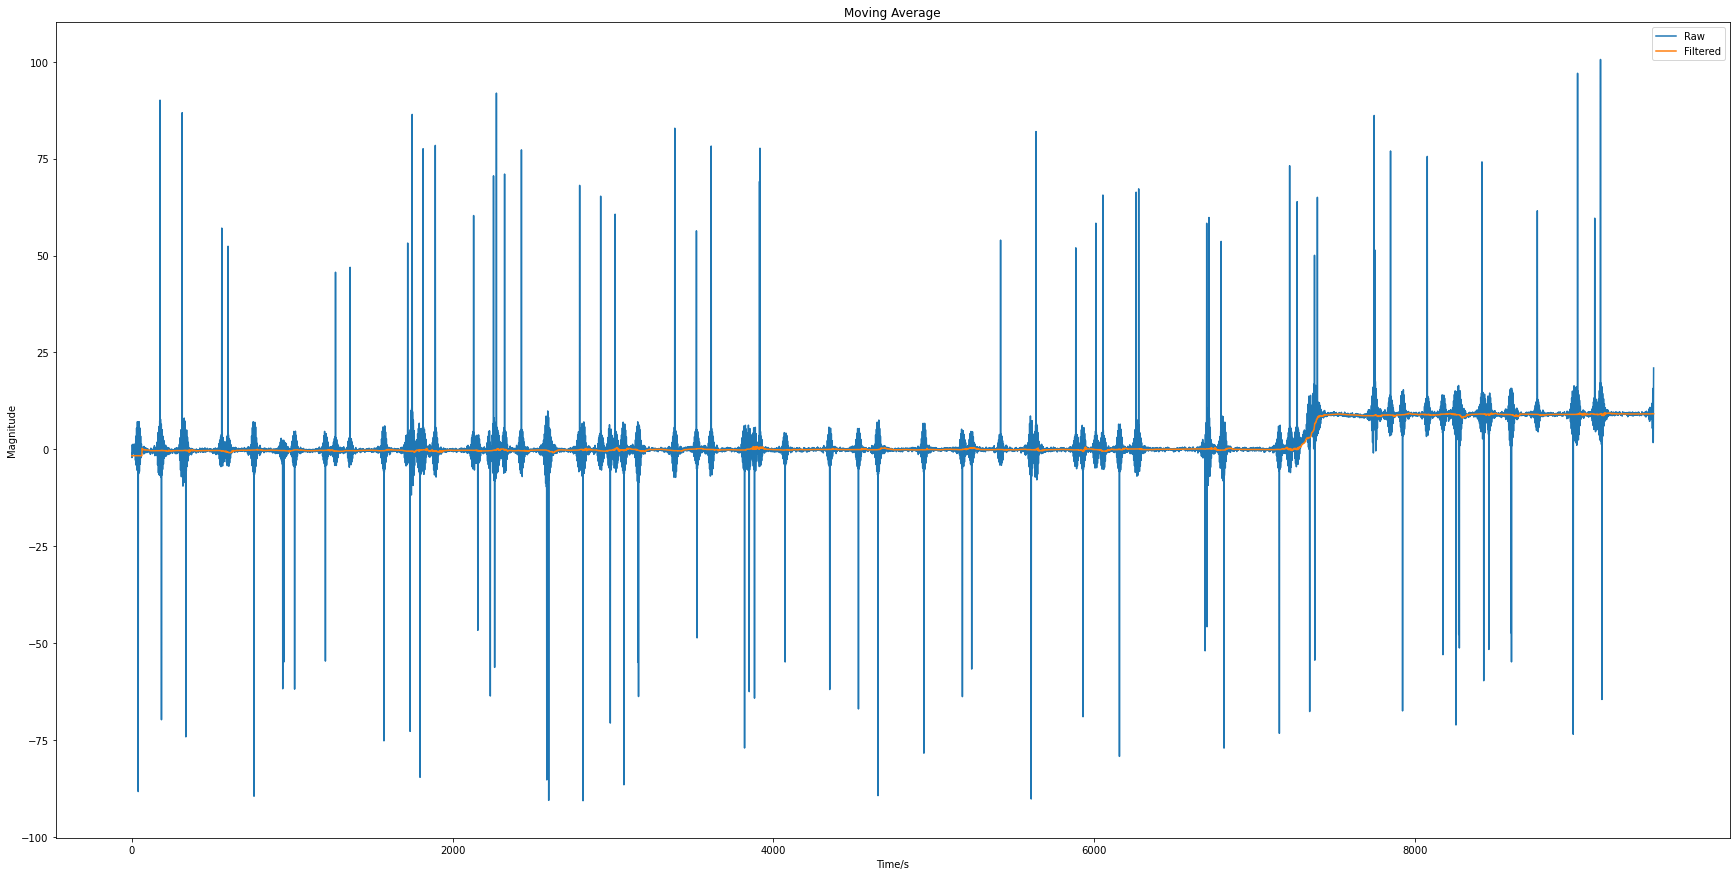

In [35]:
def median_filter(input_signal, window_sz=3):
    result = np.zeros(len(input_signal))
    
    result[:window_sz] = np.mean(input_signal[:window_sz])
    index=window_sz
    while index<len(input_signal):
        l = index-window_sz+1
        window = input_signal[l:(index+1)]
        median_val = np.median(window)
        result[index] = median_val
        index += 1
    
    return result

# def moving_avg(input_signal, window_sz=8):
#     result = np.zeros(input_signal.shape)
#     result[:window_sz] = np.mean(input_signal[:window_sz])*np.ones(window_sz)
    
#     index=window_sz
#     while index<len(input_signal):
#         l = index-window_sz+1
#         window = input_signal[l:(index+1)]
#         mean_val = np.mean(window)
#         result[index] = mean_val
#         index += 1
        
#     return result

MA_filtered_acc = []
MA_filtered_mag = []

for n in LP_filter_acc:
  MA_filtered_acc.append(median_filter(n,64))
for n in LP_filter_mag:
  MA_filtered_mag.append(median_filter(n,64))

# for n in LP_filter_acc:
#   MA_filtered_acc.append(moving_avg(n,64))
# for n in LP_filter_mag:
#   MA_filtered_mag.append(moving_avg(n,64))

fig, ax1 = plt.subplots(figsize=(30,15))

ax1.plot(LP_filter_acc[1])
ax1.plot(MA_filtered_acc[1])

ax1.set(xlabel = 'Time/s',
      ylabel = 'Magnitude',
      title = 'Moving Average')
ax1.legend(['Raw', 'Filtered'])
plt.show()